# DCGAN working example  for celibrity face generation

### The whole training process is a "tug of war" between a generator and a discriminator.  The generator will try to generate fake images that will look like true training data. The discriminator will try to classify true images from generated 'fake' images.

In [0]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


## Setting a seed to random number generator for reproducibility of results

In [0]:
# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


### Getting the celibrity images dataset 

### The compressed file is at https://weizmann.box.com/s/b0a42tkiezwcscte9kh1uxxa57dkkrey . Download the file.

In [0]:
# from google.colab import files
# files.upload()
# The compressed file is at https://weizmann.box.com/s/b0a42tkiezwcscte9kh1uxxa57dkkrey

In [0]:
#!unzip CELEBRITY_IMAGES.zip

In [0]:
#!ls -a CELEBRITY_IMAGES/

In [0]:
#!ls ./CELEBRITY_IMAGES/

### Making a directory 'data' and a subdirectory 'data/celeba'

In [0]:
mkdir data && mkdir data/celeba

In [0]:
!mv CELEBRITY_IMAGES/ data/celeba # --- placing the image folder in this newly created sub-folder  ---- #

mv: cannot stat 'CELEBRITY_IMAGES/': No such file or directory


In [0]:
ls data/celeba/

CELEBRITY_IMAGES/


### Setting the hyperparameters

In [0]:
# Root directory for dataset
dataroot = "data/celeba/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

### Cropping the image to image_size to create the dataset and pass it to a DataLoader


### Step 1 --> Use a 'Compose' function to pre-process the images  (train_transforms = transforms.Compose)

### Step 2 --> Create the dataset from pre-processed images through : 'dset.ImageFolder'

### Step 3 --> Create the DataLoader from this dataset : 'dataloader = torch.utils.data.DataLoader'

These steps were individually shown in Tutorial3 as well. 

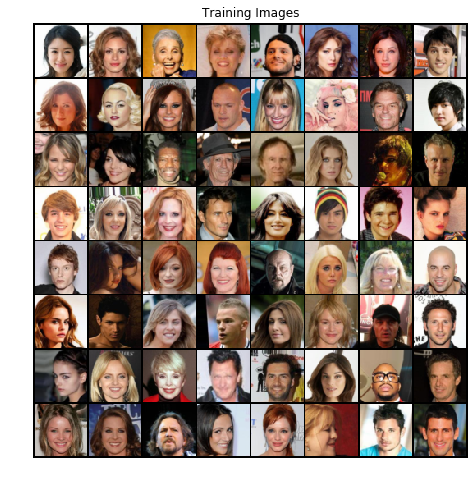

In [0]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot, 
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Weight initialization : 

### The weights to each layer are initialized from a standard normal distribution with $\mu$ =  0.00 and $\sigma$ = 0.02 , instead of a uniform random number distribution. ( For 'BatchNormalization' , $\mu$ = 1.0 )
### This is a prescription from : https://arxiv.org/pdf/1511.06434.pdf

In [0]:
# All model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


### To construct an image from latent space $z$, we need to apply upconvolution ( $nn.ConvTranspose2d$ ) . 
### Under regular convolution operation, the size of the image is reduced or remains same, where as for upconvolution, the output image has larger size. 
### To see how the maths work, follow : http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html#transposed-convolution-arithmetic

In [0]:
!wget https://pytorch.org/tutorials/_images/dcgan_generator.png

--2019-05-28 16:23:10--  https://pytorch.org/tutorials/_images/dcgan_generator.png
Resolving pytorch.org (pytorch.org)... 185.199.108.153
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85361 (83K) [image/png]
Saving to: ‘dcgan_generator.png’

dcgan_generator.png 100%[===================>]  83.36K  --.-KB/s    in 0.02s   

2019-05-28 16:23:11 (3.74 MB/s) - ‘dcgan_generator.png’ saved [85361/85361]



### Constructing the Generator part $G(z)$ and assigning weigths

### $\bf Notice ~ the~ way~ the ~ individual~ layers~ are~ declared~ within~ nn.Sequential() ~. \\One~passes~the~whole~input~to~the~Sequential~'box'~ built ~ out~ of~ different~layers.$

In [0]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [0]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Let's visualize how the upsampling is changing the shape of each intermediate layers 

In [1]:
from google.colab import files
files.upload()

Saving GenerativeNetwork.jpeg.001.jpeg to GenerativeNetwork.jpeg.001.jpeg


{'GenerativeNetwork.jpeg.001.jpeg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00H\x00H\x00\x00\xff\xe1\x00@Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x01\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x00\x1a\x00\x00\x00\x00\x00\x02\xa0\x02\x00\x04\x00\x00\x00\x01\x00\x00\x04\x00\xa0\x03\x00\x04\x00\x00\x00\x01\x00\x00\x03\x00\x00\x00\x00\x00\xff\xed\x008Photoshop 3.0\x008BIM\x04\x04\x00\x00\x00\x00\x00\x008BIM\x04%\x00\x00\x00\x00\x00\x10\xd4\x1d\x8c\xd9\x8f\x00\xb2\x04\xe9\x80\t\x98\xec\xf8B~\xff\xe2\x024ICC_PROFILE\x00\x01\x01\x00\x00\x02$appl\x04\x00\x00\x00mntrRGB XYZ \x07\xe1\x00\x07\x00\x07\x00\r\x00\x16\x00 acspAPPL\x00\x00\x00\x00APPL\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-appl\xca\x1a\x95\x82%\x7f\x10M8\x99\x13\xd5\xd1\xea\x15\x82\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\ndesc\x00\x00\x00\xfc\x00\x00\x00ecprt\x00\x00\x01d\x00\x00\x00

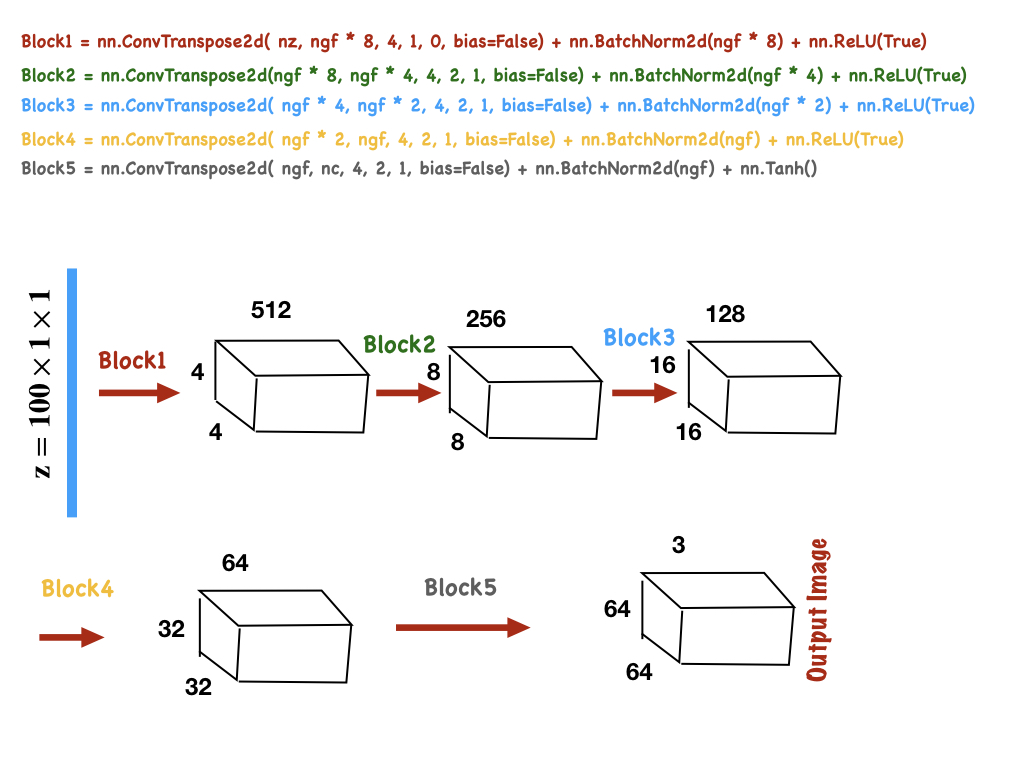

In [2]:
from IPython.display import Image
Image("GenerativeNetwork.jpeg.001.jpeg")

### Constructing the  Discriminator code $D(x)$

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [0]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### In this framework, the input images are the input data $x$. The discriminator $D(x)$  gives us the probability that the input data $x$ originates from training image rather than generated image. $D(x)$ should be high when $x$ (the image) comes from the training dataset. 

### $G(z)$  represents the generator function which maps the latent vector z to generated image space. 

### $D(G(z))$ is the probability  that the output of the generator $G$ is a real image.

### $D$ and $G$ play a minimax game in which $D$ tries to maximize the probability it correctly classifies reals and fakes :  $logD(x)$, and $G$ tries to minimize the probability that $D$ will predict its outputs are fake :  $log(1−D(G(x))$ .

### The GAN loss function : 

\begin{equation*}
\rm \bf
minimax_{G  D} V(D, G) = E_{x \sim p_{data}(x) } ~ log[D(x)] +  E_{z \sim p_{z}(z) } ~ log[1 - D(G(z))] 
\end{equation*}


### Make the training 

In [0]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    avg_errorG, avg_errorD = 0., 0.
    avg_Dx, avg_DGz1, avg_DGz2 = 0., 0., 0.
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        
        # ----- computing the average losses and discriminator --- #        
        avg_errorG += errG.item()
        avg_errorD += errD.item()
        
        avg_Dx += D_x
        avg_DGz1 += D_G_z1
        avg_DGz2 += D_G_z2

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    avg_errorG = avg_errorG/len(dataloader.dataset)
    avg_errorD = avg_errorD/len(dataloader.dataset)
    
    avg_Dx = avg_Dx/len(dataloader.dataset)
    avg_DGz1 = avg_DGz1/len(dataloader.dataset)
    avg_DGz2 = avg_DGz2/len(dataloader.dataset)
        
    G_losses.append(avg_errorG)
    D_losses.append(avg_errorD)
    
    if epoch % 10 == 1:
            print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs,
                     avg_errorD, avg_errorG, avg_Dx, avg_DGz1, avg_DGz2))


Starting Training Loop...
[1/100]	Loss_D: 0.0028	Loss_G: 0.1392	D(x): 0.0073	D(G(z)): 0.0009 / 0.0000
[11/100]	Loss_D: 0.0060	Loss_G: 0.0322	D(x): 0.0062	D(G(z)): 0.0016 / 0.0007
[21/100]	Loss_D: 0.0050	Loss_G: 0.0478	D(x): 0.0064	D(G(z)): 0.0014 / 0.0002
[31/100]	Loss_D: 0.0067	Loss_G: 0.0438	D(x): 0.0061	D(G(z)): 0.0017 / 0.0004
[41/100]	Loss_D: 0.0059	Loss_G: 0.0384	D(x): 0.0061	D(G(z)): 0.0017 / 0.0005
[51/100]	Loss_D: 0.0038	Loss_G: 0.0318	D(x): 0.0065	D(G(z)): 0.0013 / 0.0004
[61/100]	Loss_D: 0.0057	Loss_G: 0.0338	D(x): 0.0062	D(G(z)): 0.0016 / 0.0008
[71/100]	Loss_D: 0.0027	Loss_G: 0.0306	D(x): 0.0068	D(G(z)): 0.0011 / 0.0003
[81/100]	Loss_D: 0.0027	Loss_G: 0.0268	D(x): 0.0068	D(G(z)): 0.0011 / 0.0005
[91/100]	Loss_D: 0.0048	Loss_G: 0.0306	D(x): 0.0062	D(G(z)): 0.0015 / 0.0006


### Results : Loss evolution  

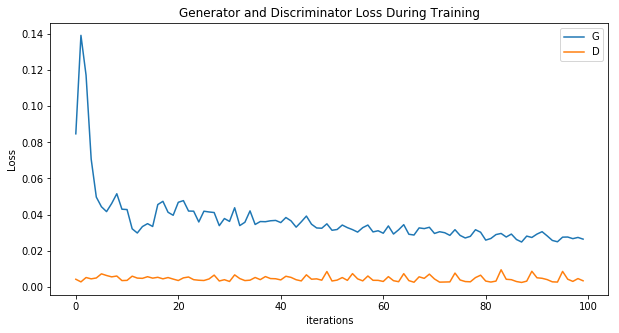

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml() )

Output hidden; open in https://colab.research.google.com to view.

### Real Vs Fake Images 

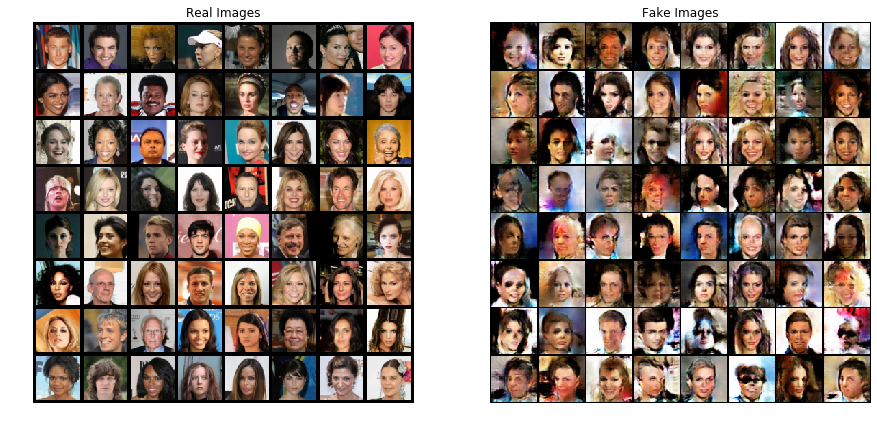

In [0]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


# Let's generate few fake images and try to find it's nearest image in real list

In [0]:
fixed_noise_new = torch.randn(5, nz, 1, 1, device=device) # --- generating 5 random number each of shape (100 X 1 X 1) ---- #

### For each $z$ we get a $G(z)$

In [0]:
fake_new = netG(fixed_noise_new).detach().cpu() # --- obtaining five fake images ---- #

### We will use $L1$ distance (  $d = \sum_{i = 1}^{N} | x_i -y_i|$ ) between the real and fake images to estimate closest matching image

In [0]:
loss = nn.L1Loss()

In [0]:
Matched_Index = []

for test_im in range( len(fake_new) ) : 
    Nearest_Val, nearest_idx = 999999., -1

    for i_im in range(128) : 


      val = loss(fake_new[test_im], real_batch[0].to(device)[i_im].cpu() ).item()

      if(val < Nearest_Val) : 
        Nearest_Val = val
        nearest_idx = i_im
        
        
    Matched_Index.append(nearest_idx)

In [0]:
Matched_Index

[17, 49, 108, 11, 123]

### Plotting the fake and matched real image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

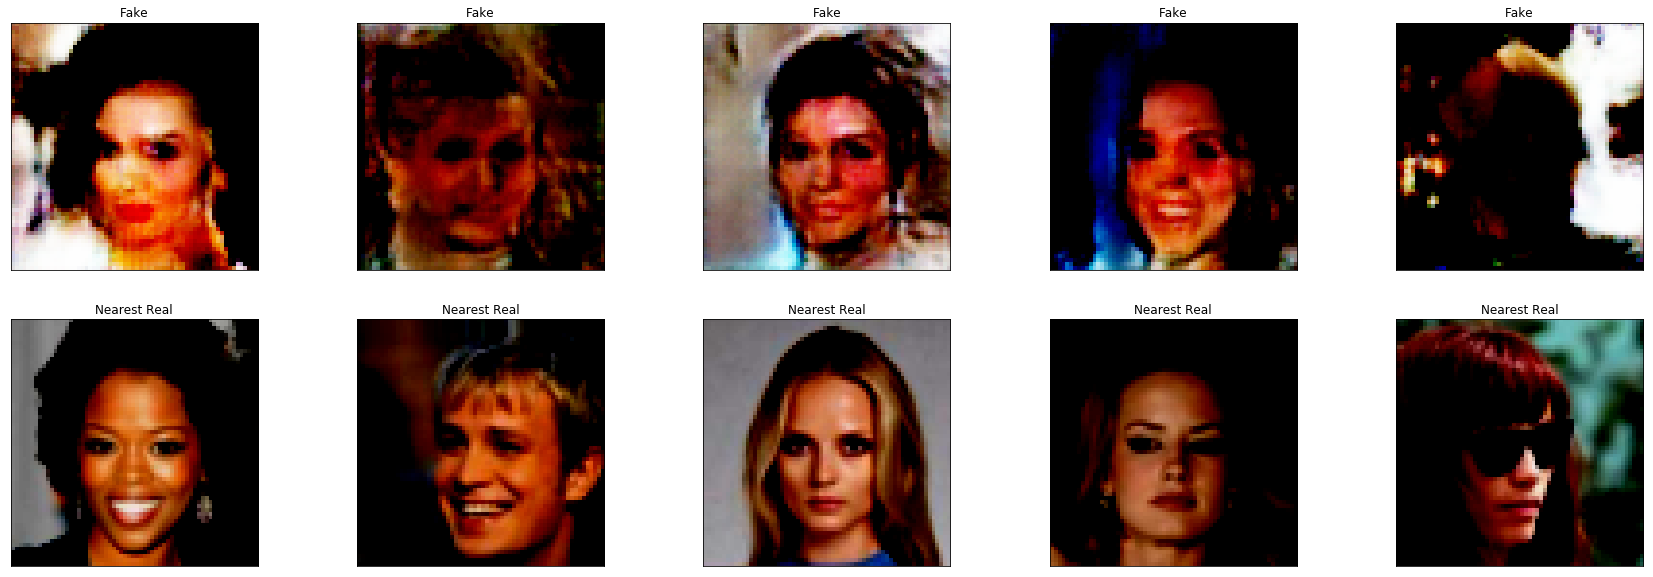

In [0]:
fig = plt.figure(figsize=(30,10))

for idx in np.arange(10):
  
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    if(idx < 5) : 
      ax.imshow( np.transpose(fake_new[idx],(1,2,0))  )
      plt.title('Fake')
    else : 
      ax.imshow(np.transpose(real_batch[0].to(device)[ Matched_Index[idx-5] ].cpu(),(1,2,0)))
      plt.title('Nearest Real')

# Homework-6 !!!! :) :) 

## The dataset is staged at : https://weizmann.box.com/s/fdueo24q6tx22v4pkunhn5rd7nbhg420
### This is a collection of flower images. Repeat the exercise with this new dataset